## <font color='blue'>0. Load data</font>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle

import time
import sys
import os

sys.path.append('./src')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, accuracy_score

def rmse(y_true,y_pred):
    return mean_squared_error(y_true,y_pred,squared=False)

In [3]:
# read Bike Sharing data
path = './data/bike_sharing/'
df = pd.read_csv(path + "hour.csv.gz", compression="gzip")

orig_predictor_headers = list(df)
outcome_header = "cnt"
used_headers = orig_predictor_headers
used_headers.remove("instant")
used_headers.remove("dteday")
used_headers.remove("casual")
used_headers.remove("registered")
df2 = df[used_headers]

def add_dummy(v, data):
    dummy_cols = v
    dummy = pd.get_dummies(df[dummy_cols], drop_first=True)
    dummy.columns = [dummy_cols+"_{}".format(i) for i in range(dummy.shape[1])]
    data = pd.concat([data, dummy], axis=1)
    data.drop([dummy_cols], axis=1, inplace=True)
    return data

USE_DUMMIES = True
if USE_DUMMIES:
    data = df2
    data = add_dummy('season',data)
    data = add_dummy('weathersit',data)
    
feature_names = list(data)
feature_names.remove('cnt')

y = data['cnt'].values
X = data[feature_names].values

print(X.shape, y.shape)
feature_names

(17379, 16) (17379,)


['yr',
 'mnth',
 'hr',
 'holiday',
 'weekday',
 'workingday',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'season_0',
 'season_1',
 'season_2',
 'weathersit_0',
 'weathersit_1',
 'weathersit_2']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train_0, X_valid, y_train_0, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

## <font color='blue'>1. EDA</font>

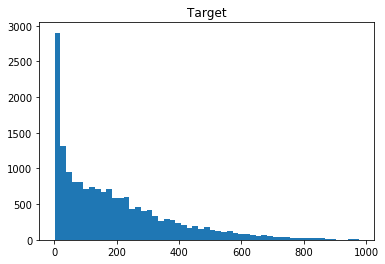

In [5]:
_ = plt.hist(y, bins='auto')  # arguments are passed to np.histogram
plt.title("Target")
plt.show()

In [6]:
N = X_train.shape[0]
p = X_train.shape[1]
print('N:{}, p:{}'.format(N,p))

N:13903, p:16


## <font color='blue'>2. Fit DNN model</font>

### 2-1. Generate tensor slices

In [7]:
tf.random.set_seed(1)
train_ds = tf.data.Dataset.from_tensor_slices((X_train_0, y_train_0)).shuffle(1000).batch(1000).repeat()

### 2-2. Model specification

In [8]:
dnn_model = tf.keras.Sequential(
        [
        tf.keras.layers.Input(shape=(X_train.shape[1],), name='input'),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(30, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')
        ]
    )

In [9]:
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                510       
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
_________________________________________________________________


### 2-3. Set model optimization hyperparameters

In [10]:
dnn_model.compile(
    loss=tf.keras.losses.MeanSquaredError(name='loss'),
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01),
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='acc')]
)    

### 2-4 Fit DNN

In [11]:
EVALUATION_INTERVAL = 1000
EPOCHS = 20
    
history = dnn_model.fit(train_ds,
                        epochs=EPOCHS,
                        steps_per_epoch=EVALUATION_INTERVAL,
                        validation_data=(X_valid, y_valid))

Epoch 1/20
1000/1000 [==============================] - 4s 4ms/step - loss: 11757.5283 - acc: 108.4321 - val_loss: 5050.4170 - val_acc: 71.0663
Epoch 2/20
1000/1000 [==============================] - 4s 4ms/step - loss: 3777.0613 - acc: 61.4578 - val_loss: 3458.5222 - val_acc: 58.8092
Epoch 3/20
1000/1000 [==============================] - 4s 4ms/step - loss: 2857.7551 - acc: 53.4580 - val_loss: 3447.1797 - val_acc: 58.7127
Epoch 4/20
1000/1000 [==============================] - 4s 4ms/step - loss: 2459.7866 - acc: 49.5962 - val_loss: 2709.8958 - val_acc: 52.0567
Epoch 5/20
1000/1000 [==============================] - 4s 4ms/step - loss: 2215.9624 - acc: 47.0740 - val_loss: 2626.0076 - val_acc: 51.2446
Epoch 6/20
1000/1000 [==============================] - 4s 4ms/step - loss: 2091.2207 - acc: 45.7299 - val_loss: 2786.6667 - val_acc: 52.7889
Epoch 7/20
1000/1000 [==============================] - 3s 3ms/step - loss: 1982.8195 - acc: 44.5289 - val_loss: 2558.2751 - val_acc: 50.5794
Epoc

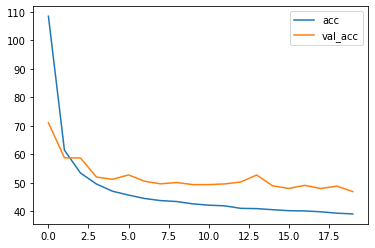

In [12]:
plt.plot(history.history['acc'], label="acc")
plt.plot(history.history['val_acc'], label="val_acc")
plt.legend(loc="upper right")
plt.show()

In [13]:
pred_dnn_train = dnn_model.predict(X_train)
pred_dnn_test = dnn_model.predict(X_test)
print('Train RMSE:{:3.3f} / Test RMSE:{:3.3f}'.format(
            rmse(y_train,pred_dnn_train),
            rmse(y_test,pred_dnn_test)))

Train RMSE:40.073 / Test RMSE:47.642


## <font color='blue'>3. Mixture Linear Model</font>

In [14]:
import mixturelinearmodel
from mixturelinearmodel import MixtureLinearModel

In [15]:
MLM = MixtureLinearModel(dnn_model, verbose=True)
MLM.statsmodel = False

In [16]:
MLM.compute_CELL(X_train,K=100,random_seed=1)

100%|██████████| 3/3 [03:02<00:00, 60.80s/it]


# of CELL:1712 / min size:1 / avg size:8.1 / max size:149 / # of singlton CELL:538


In [17]:
# fit MLM-cell
MLM.fit_LocalModels(X_train, y_train, 
                    eps=0.01, num_noise_samp=100, 
                    classification=False, alpha=0, max_iter=10000,random_seed=1)

100%|██████████| 1712/1712 [00:00<00:00, 1726.29it/s]


In [18]:
pred_lmm_train = MLM.predict(X_train, covariance_type='full', covariance_tied=True, uniform_prior=False,)
pred_lmm_test = MLM.predict(X_test, covariance_type='full', covariance_tied=True, uniform_prior=False,)

100%|██████████| 1712/1712 [00:01<00:00, 1166.78it/s]


In [19]:
print('MLM-CELL: Train RMSE:{:3.3f} / Test RMSE:{:3.3f}'.format(
            rmse(y_train,np.array(pred_lmm_train)),
            rmse(y_test,np.array(pred_lmm_test))))

MLM-CELL: Train RMSE:52.741 / Test RMSE:60.850


In [20]:
# fit MLM-EPIC
MLM.fit_MergedLocalModels(150, classification=False, alpha=0, max_iter=10000, random_seed=1)

100%|██████████| 1712/1712 [04:20<00:00,  6.57it/s]
./src\mixturelinearmodel.py:392: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  LocalModelsTree = linkage(self.dist_mat_avg, 'ward')
100%|██████████| 150/150 [00:00<00:00, 531.92it/s]


In [21]:
pred_epic_train = MLM.predict(X_train,  merged=True, covariance_type='full', covariance_tied=True, uniform_prior=False)
pred_epic_test = MLM.predict(X_test, merged=True, covariance_type='full', covariance_tied=True, uniform_prior=False)

100%|██████████| 150/150 [00:01<00:00, 91.79it/s]


In [22]:
print('MLM-EPIC: Train RMSE:{:3.3f} / Test RMSE:{:3.3f}'.format(
            rmse(y_train,np.array(pred_epic_train)),
            rmse(y_test,np.array(pred_epic_test))))

MLM-EPIC: Train RMSE:62.777 / Test RMSE:66.684


In [23]:
MLM.save_dict('./output/mlm_bikesharing')

---

## <font color='blue'>4. Interpretation</font>

### <font color='orange'>4-1. regression coefficients</font>

In [58]:
import utils
import importlib
importlib.reload(utils)
import utils
from utils import plot_mosaic, plot_ci, explainable_tree, explainable_condition, explainable_dim, highest_explainable_dim, plot_id_1d, plot_id_2d, plot_id_3d

In [54]:
from utils import plot_mosaic, plot_ci, explainable_tree, explainable_condition, explainable_dim, highest_explainable_dim, plot_id_1d, plot_id_2d, plot_id_3d

In [32]:
pred_epic_train = MLM.predict(X_train,  merged=True, covariance_type='full', covariance_tied=True, uniform_prior=False)

100%|██████████| 150/150 [00:03<00:00, 47.86it/s]


In [33]:
MLM.feature_names = feature_names

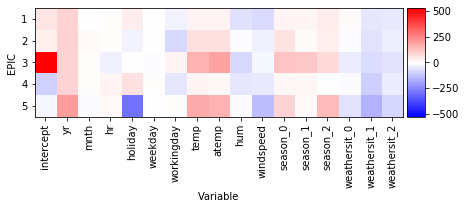

In [34]:
plot_mosaic(MLM, epic_id=range(5), log_trans=False)

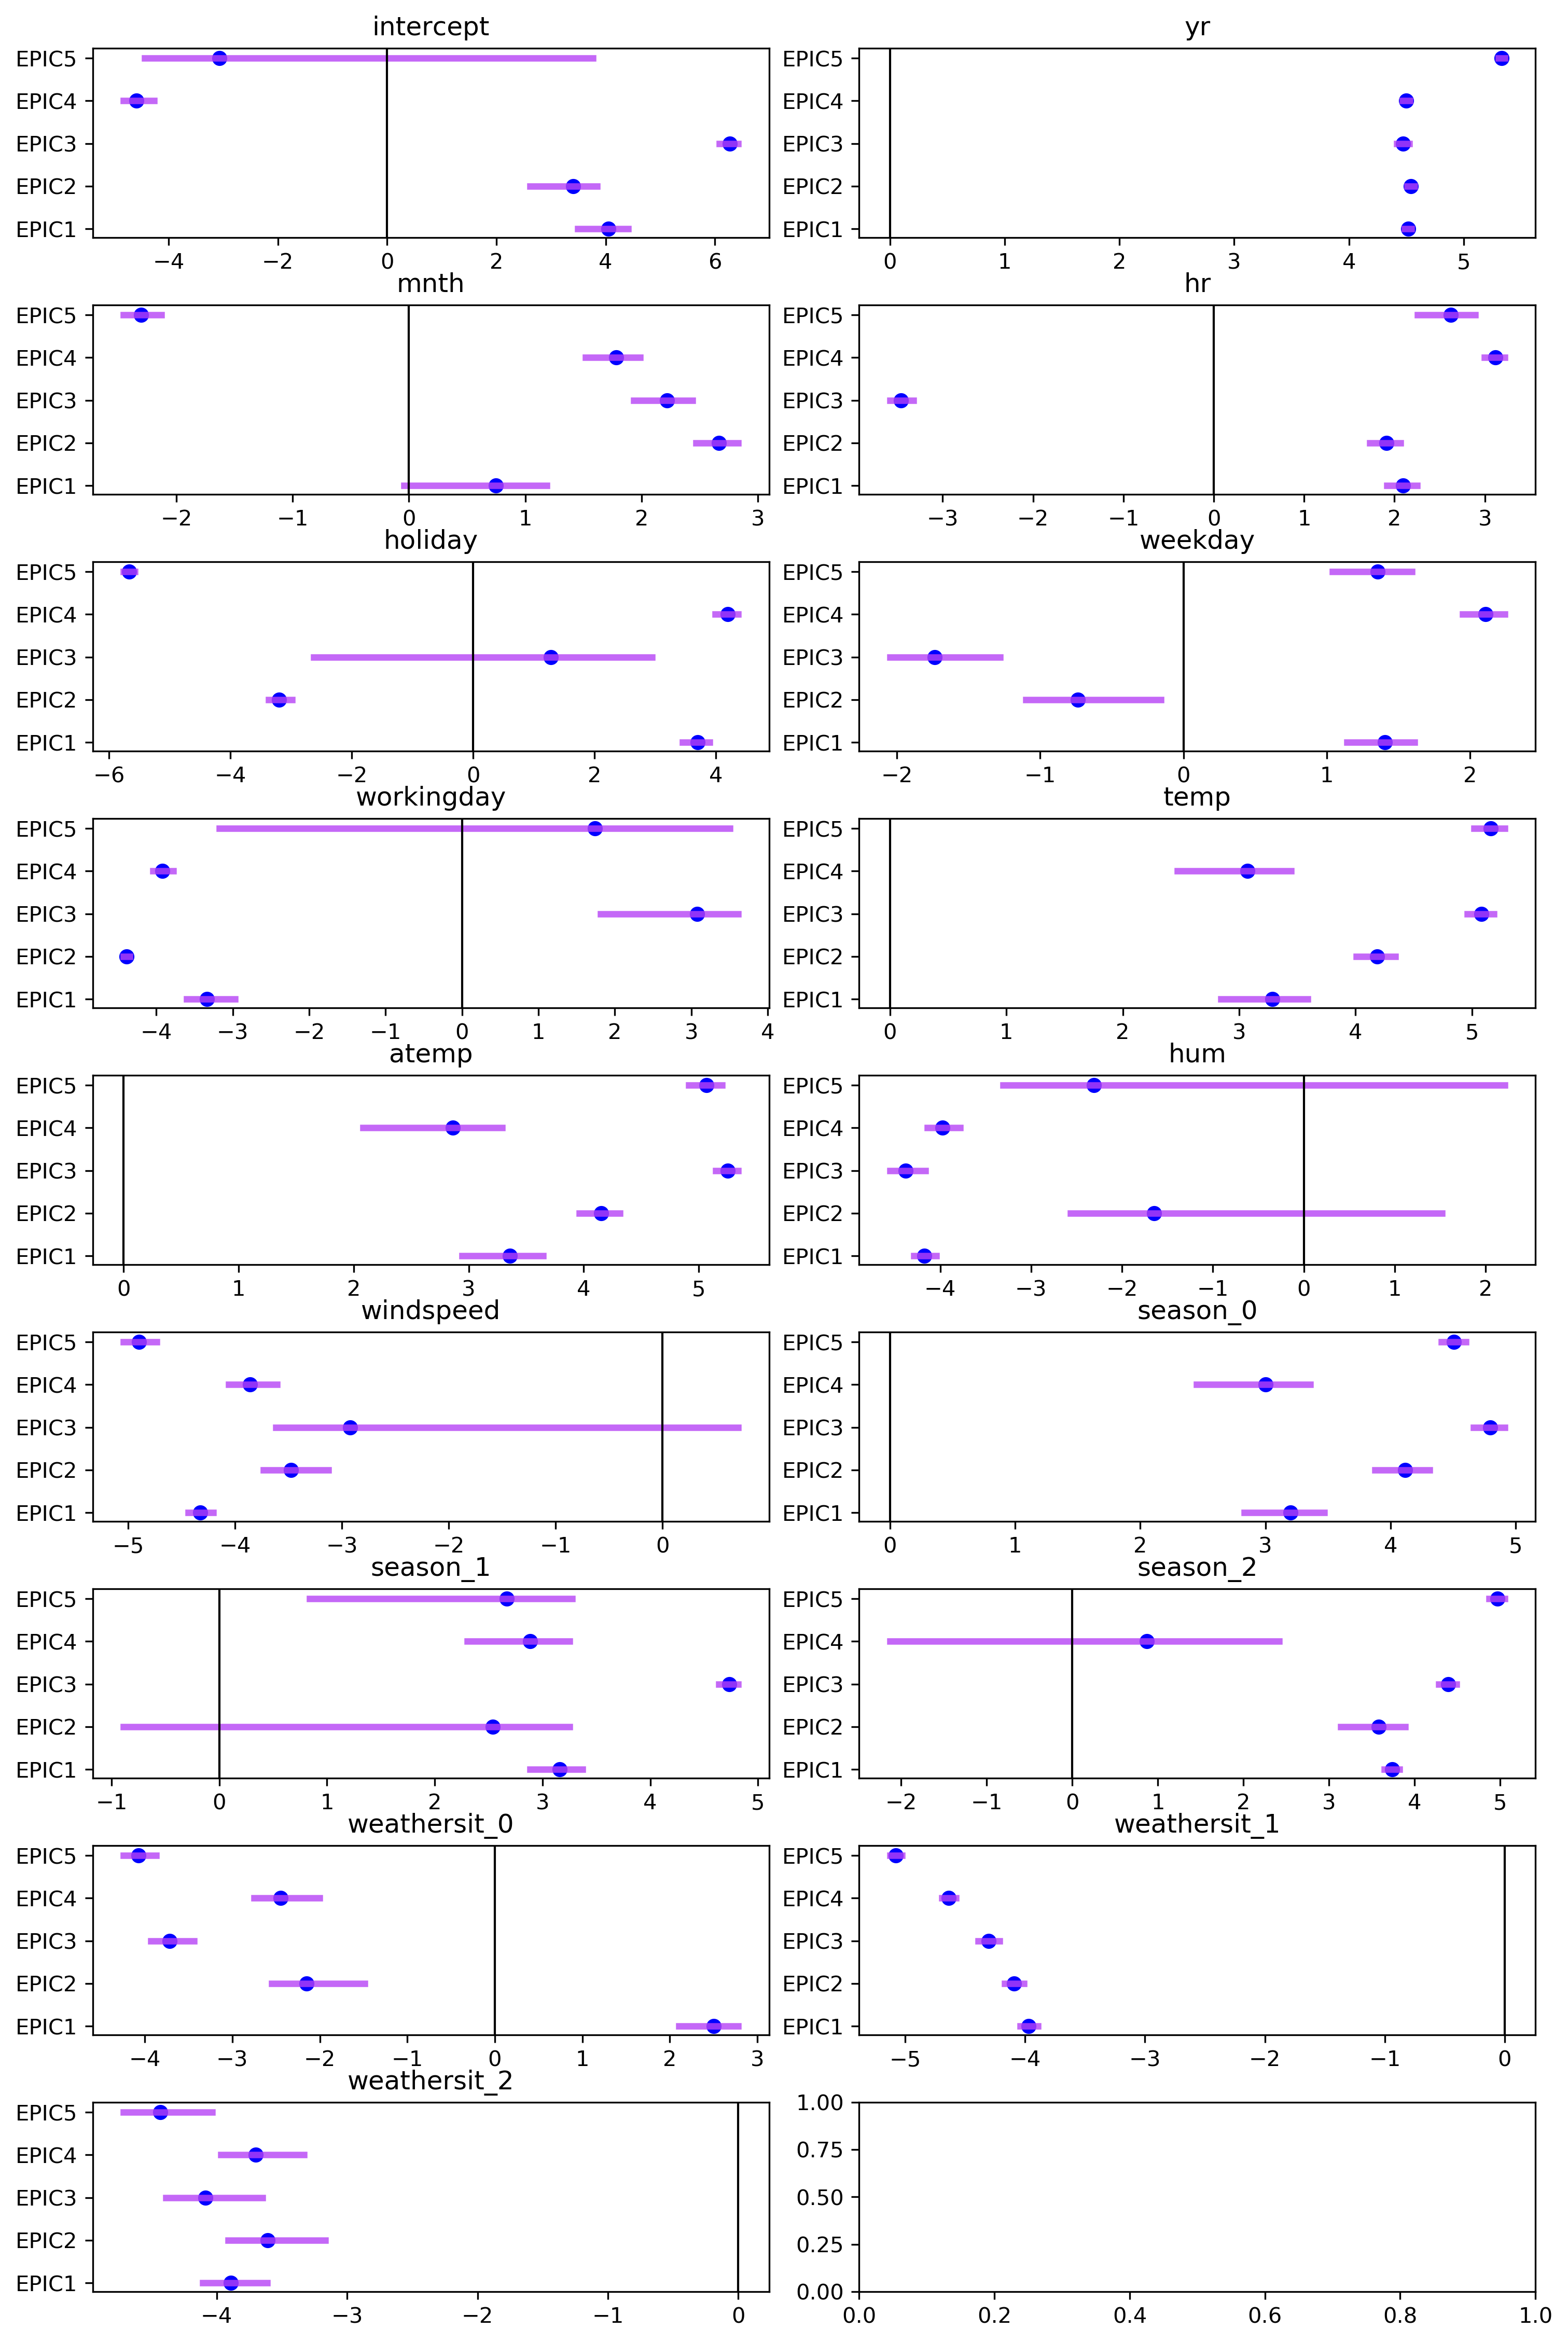

In [35]:
f, axs = plt.subplots(9,2,figsize=(10,15),dpi=300)
f.tight_layout()
for i in range(MLM.p+1):
    ax = plt.subplot(9,2,i+1)
    plot_ci(MLM,i,epic_id=range(5),ax=ax,title=True)

### <font color='orange'>4-2. Low Dimensional Subspace</font>

In [59]:
explainable_tree(MLM, X_train, psi=0.8, epic_id=range(5))

EPIC 0(orig id 86): found tree with max pure size 727 and total pure size 883 for 883
EPIC 1(orig id 85): found tree with max pure size 377 and total pure size 488 for 488
EPIC 2(orig id 28): found tree with max pure size 166 and total pure size 456 for 456
EPIC 3(orig id 103): found tree with max pure size 182 and total pure size 370 for 370
EPIC 4(orig id 87): found tree with max pure size 66 and total pure size 307 for 307


In [40]:
exp_cond = explainable_condition(MLM, X, xi=50, epic_id=range(5))

In [41]:
exp_cond

[[array([['727', 'mnth > 3.5'],
         ['727', 'hr > 11.5'],
         ['727', 'hr <= 14.5'],
         ['727', 'workingday == 1']], dtype='<U21')],
 [array([['51', 'yr != 1'],
         ['51', 'mnth <= 2.5'],
         ['51', 'hr > 10.5'],
         ['51', 'hr <= 14.5'],
         ['51', 'workingday != 1'],
         ['51', 'season_0 != 1']], dtype='<U21'),
  array([['377', 'mnth <= 3.5'],
         ['377', 'hr <= 14.5'],
         ['377', 'hr > 9.5'],
         ['377', 'workingday == 1'],
         ['377', 'season_0 != 1']], dtype='<U21')],
 [array([['166', 'mnth > 3.5'],
         ['166', 'hr <= 21.5'],
         ['166', 'hr > 20.5'],
         ['166', 'workingday == 1'],
         ['166', 'season_2 != 1']], dtype='<U21')],
 [array([['88', 'hr <= 10.5'],
         ['88', 'hr > 9.5'],
         ['88', 'workingday == 1'],
         ['88', 'season_0 != 1'],
         ['88', 'season_1 == 1'],
         ['88', 'weathersit_1 != 1']], dtype='<U21'),
  array([['182', 'hr <= 11.5'],
         ['182', 'hr > 9.5

### <font color='orange'>4-3. Prominent Region </font>

In [47]:
explainable_dim(MLM,X_train,epic_id=range(5),max_dim=p)

  0%|          | 0/16 [00:00<?, ?it/s]

[[86 2 1 (2, 5, 1) 0.8167597765363128]]


  0%|          | 0/16 [00:00<?, ?it/s]

[[85 3 2 (0, 1, 2, 5) 0.8382775119617225]]


  0%|          | 0/16 [00:00<?, ?it/s]

[[28 6 0 (0, 2, 1, 5, 3, 12, 4) 0.8091428571428572]
 [28 6 8 (0, 2, 1, 5, 3, 12, 14) 0.8017524644030669]]


  0%|          | 0/16 [00:00<?, ?it/s]

[[103 4 1 (0, 1, 2, 5, 4) 0.8041775456919059]
 [103 4 6 (0, 1, 2, 5, 10) 0.8189987163029525]
 [103 4 7 (0, 1, 2, 5, 11) 0.8086253369272237]
 [103 4 8 (0, 1, 2, 5, 12) 0.8133333333333334]
 [103 4 10 (0, 1, 2, 5, 14) 0.8093994778067884]]


100%|██████████| 10/10 [00:21<00:00,  2.18s/it]

[[87 6 2 (0, 1, 2, 5, 4, 3, 8) 0.8237082066869301]
 [87 6 5 (0, 1, 2, 5, 4, 3, 11) 0.8081123244929797]
 [87 6 6 (0, 1, 2, 5, 4, 3, 12) 0.8018867924528302]
 [87 6 8 (0, 1, 2, 5, 4, 3, 14) 0.8111455108359134]]


In [50]:
hed =[]
for i in range(5):
    hed.append(highest_explainable_dim(MLM,i))
# epic id / explainable_dim / feature_names / explainable_rate
hed

[(86, (2, 5, 1), ['hr', 'workingday', 'mnth'], 0.82),
 (85, (0, 1, 2, 5), ['yr', 'mnth', 'hr', 'workingday'], 0.84),
 (28,
  (0, 2, 1, 5, 3, 12, 4),
  ['yr', 'hr', 'mnth', 'workingday', 'holiday', 'season_2', 'weekday'],
  0.81),
 (103, (0, 1, 2, 5, 10), ['yr', 'mnth', 'hr', 'workingday', 'season_0'], 0.82),
 (87,
  (0, 1, 2, 5, 4, 3, 8),
  ['yr', 'mnth', 'hr', 'workingday', 'weekday', 'holiday', 'hum'],
  0.82)]